# Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist['data'].shape

(70000, 784)

In [4]:
mnist['target'].shape

(70000,)

In [6]:
mnist['target'].value_counts(normalize = True)

1    0.112529
7    0.104186
3    0.102014
2    0.099857
9    0.099400
0    0.098614
6    0.098229
8    0.097500
4    0.097486
5    0.090186
Name: class, dtype: float64

# Data Splits
I will use mnist.data and mnist.target to split my data into features and targets, then into a validation split

In [7]:
X = mnist['data']
y = mnist['target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# No PCA
Lets begin without using PCA. I'll create the pipeline for a KNN model and fit it to the data. I'll wait to predict and score the outcome once this is done. We are going to use the base hyperparameters for KNN

In [9]:
scaler = StandardScaler()
KNN = KNeighborsClassifier()
noPCApipe = make_pipeline(scaler, KNN)
noPCApipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

# PCA
Same thing as above but using PCA. First lets start by tuning my PCA

In [10]:
scalepca = StandardScaler()
scaledX = scalepca.fit_transform(X)
pca = PCA()
pca.fit(scaledX)

PCA()

Visualizing a Scree Plot to decide which n_components to use

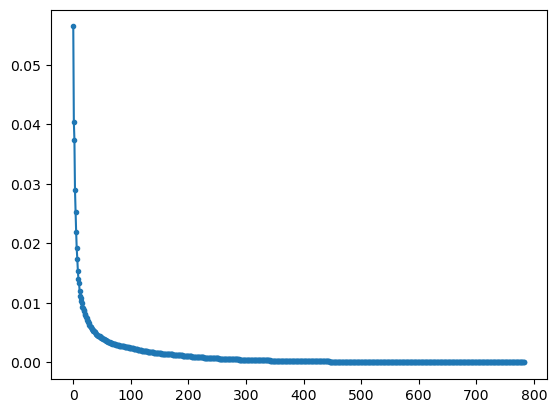

In [11]:
plt.plot(pca.explained_variance_ratio_, marker = '.');

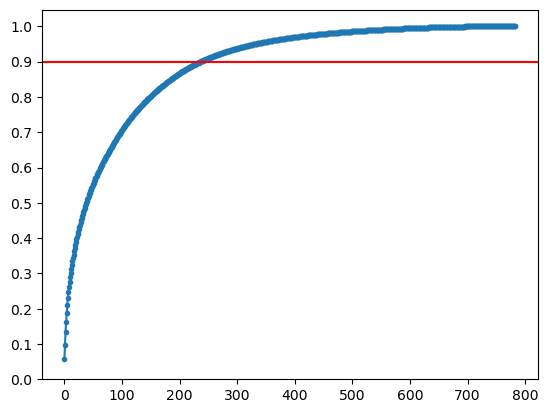

In [12]:
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.axhline(y = 0.9, color = 'r')
plt.yticks(ticks = np.arange(0,1.1,0.1));

It looks like there could be a big drop off around 50 or so. Using the Cumulative Sum graph, I think I want to take the n_components to where they explain 90% of the variance. I cannot tell the exact number of components looking at the graph, but it looks like it might be around 200.

I will now combine PCA to the scaler and create a preprocessor. Then I will add that preprocessor to a pipeline that includes my KNN model

In [13]:
pca90 = PCA(n_components=.9)
preprocessor = make_pipeline(scaler, pca90)
KNNPCA = KNeighborsClassifier()

PCApipe = make_pipeline(preprocessor, KNNPCA)

In [14]:
PCApipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.9))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

# Time It

In [15]:
%%time
preds_pca = PCApipe.predict(X_test)

CPU times: total: 4.55 s
Wall time: 2.32 s


In [16]:
%%time
preds_no_pca = noPCApipe.predict(X_test)

CPU times: total: 14.3 s
Wall time: 6.64 s


# Score It

In [18]:
print(f'KNN without PCA score, Training Accuracy: {noPCApipe.score(X_train, y_train)}')
print(f'KNN without PCA score, Testing Accuracy: {noPCApipe.score(X_test, y_test)}')
print(f'KNN with PCA score, Training Accuracy: {PCApipe.score(X_train, y_train)}')
print(f'KNN with PCA score, Testing Accuracy: {PCApipe.score(X_test, y_test)}')

KNN without PCA score, Training Accuracy: 0.9625904761904762
KNN without PCA score, Testing Accuracy: 0.9442285714285714
KNN with PCA score, Training Accuracy: 0.9679428571428571
KNN with PCA score, Testing Accuracy: 0.9517714285714286


* Which model performed best on the Test Set?
    * the model with PCA performed best. Which was a surprise to me
* Which model was the fastest at making predictions?
   * the model with PCA was the fastest 